In [131]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [132]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [133]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [134]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [135]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [136]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [137]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [138]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [139]:
# Find the most recent date in the data set.

# method1
most_recent_date = session.query(func.max(Measurement.date)).first()

# method2
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

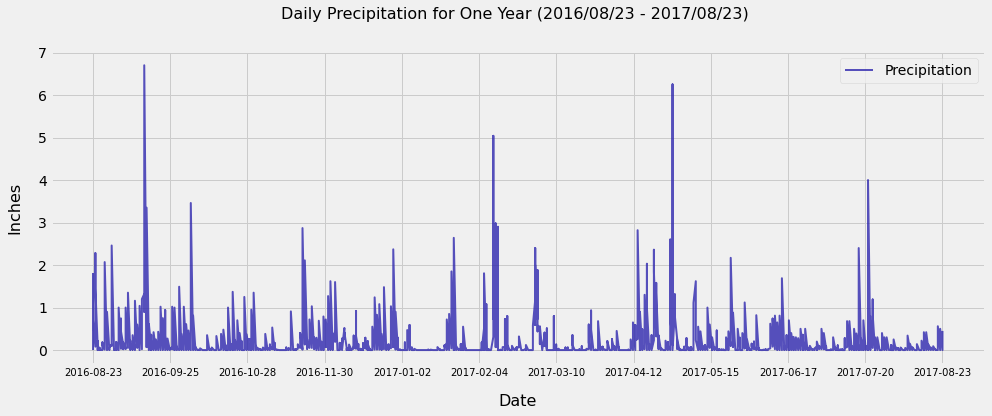

In [140]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = most_recent_date[0]

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()
date_12_months_back = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
get_data_last_12_mons = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= date_12_months_back).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_mons_data_df = pd.DataFrame(get_data_last_12_mons, columns =['Date', 'Precipitation'])

# drop rows with nulls because a record is useless with out a date or precipitation value
last_12_mons_data_df = last_12_mons_data_df.dropna()

# convert the datatype of date to datetime
last_12_mons_data_df["Date"]= pd.to_datetime(last_12_mons_data_df["Date"])

#set the index to the date column
last_12_mons_data_df.set_index('Date', inplace=True)

# Sort the dataframe by date
last_12_mons_data_df = last_12_mons_data_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# plot

min_date = last_12_mons_data_df.index.min()
max_date = last_12_mons_data_df.index.max()
fig, ax = plt.subplots(figsize=(14,6))
xticks = pd.date_range(min_date, max_date, periods=12)
last_12_mons_data_df.plot(y=['Precipitation'],ax=ax,xticks=xticks, linewidth=2,alpha=0.8, color="#2e27ae")
plt.xticks(rotation=0, ha='center')

plt.yticks(size=14)
plt.xticks(fontsize=10)
#plt.legend(frameon=False)
plt.xlabel('Date',fontsize=16,color='black',labelpad=16)
plt.ylabel('Inches',fontsize=16,color='black',labelpad=16)
plt.title(f'Daily Precipitation for One Year ({min_date.strftime("%Y/%m/%d")} - {max_date.strftime("%Y/%m/%d")}) ',fontsize=16,pad=32)
plt.tight_layout()
plt.savefig("Plot_Images/daily_precp.jpeg")
plt.show()

In [141]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# precipitation_summ_stat = last_12_mons_data_df.agg({"Precipitation":['min','max','mean','median','var','std','sem']})
# precipitation_summ_stat

last_12_mons_data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [142]:
# Design a query to calculate the total number stations in the dataset
total_no_of_stations = session.query(Measurement.station).distinct().count()
print(f"The total number stations in the dataset: {total_no_of_stations}")

The total number stations in the dataset: 9


In [143]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
sel = [Measurement.station, Station.name, func.count(Measurement.id).label("No_of_Stations")]
station_list = session.query(*sel).filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

# Display using Dataframe 
pd.DataFrame(station_list, columns=['Station ID', 'Station Name', 'No_Of_Records']) 

,Station ID,Station Name,No_Of_Records
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [144]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_sation = session.query(Measurement.station, Station.name,).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
active_sation_id   = active_sation[0]
active_sation_name = active_sation[1]

active_station_details = session.query(Measurement.station, \
    func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_sation_id).\
    group_by(Measurement.station).all()
 
print (f"The Most Active Station Details :")
print ("-------------------------------------")
print (f" Name: {active_sation_name}\n Station ID: {active_sation_id}\n Lowest Temp : {round((active_station_details[0][1]),2)}")
print (f" Highest Temp : {round((active_station_details[0][2]),2)}\n Average Temp : {round((active_station_details[0][3]),2)}")



The Most Active Station Details :
-------------------------------------
 Name: WAIHEE 837.5, HI US
 Station ID: USC00519281
 Lowest Temp : 54.0
 Highest Temp : 85.0
 Average Temp : 71.66


In [145]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Using the previously retrieved active_sation_id and date_12_months_back variables
get_temp_obsr_last_12_months = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_sation_id).\
    filter(Measurement.date >= date_12_months_back).\
    order_by(Measurement.date).all()  

# Save the query results as a Pandas DataFrame and set the index to the date column
temp_obs_df = pd.DataFrame(get_temp_obsr_last_12_months, columns =['date', 'tobs'])
temp_obs_df.set_index('date',inplace=True)    

temp_obs_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


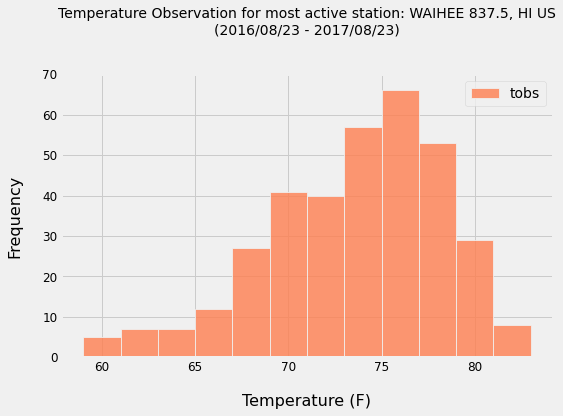

In [146]:

# plot the results as a histogram
fig = plt.figure(figsize = (8,6))
ax = fig.gca()

temp_obs_df.plot.hist(ax = ax, bins=12, alpha=0.8,edgecolor='#f1f1f1', linewidth=1,color='coral')
plt.title(f'Temperature Observation for most active station: {active_sation_name}\n({min_date.strftime("%Y/%m/%d")} - {max_date.strftime("%Y/%m/%d")})',fontsize=14,pad=40)
plt.xlabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Frequency',fontsize=16,color='black',labelpad=20)
plt.legend(loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,70)
plt.tight_layout()
plt.savefig("Plot_Images/tobs_hist.jpeg")
plt.show()


# Bonus: Temperature Analysis I

In [147]:
# "tobs" is "temperature observations"
df = pd.read_csv('Resources/hawaii_measurements.csv')
df.head()
#df.dtypes

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


In [148]:
# Convert the date column format from string to datetime
df['date'] = pd.to_datetime(df['date'])
df.dtypes

station            object
date       datetime64[ns]
prcp              float64
tobs                int64
dtype: object

In [149]:
# Set the date column as the DataFrame index
df.set_index('date',inplace=True)
df

,station,prcp,tobs
date,,,
2010-01-01,USC00519397,0.08,65
2010-01-02,USC00519397,0.00,63
2010-01-03,USC00519397,0.00,74
2010-01-04,USC00519397,0.00,76
2010-01-06,USC00519397,NaN,73
...,...,...,...
2017-08-19,USC00516128,0.09,71
2017-08-20,USC00516128,NaN,78
2017-08-21,USC00516128,0.56,76


### Compare June and December data across all years 

In [150]:
from scipy import stats

In [151]:
# Filter data for desired months
# Method 1: Pandas Dataframe

df_june = df.loc[pd.DatetimeIndex(df.index).month == 6]
df_june = df_june.dropna(subset=['tobs'])
df_june = df_june.sort_index()

df_dec = df.loc[pd.DatetimeIndex(df.index).month == 12]
df_dec = df_dec.dropna(subset=['tobs'])
df_dec = df_dec.sort_index()

In [152]:
# # Method 2: SQLAlchemy Commented this out because i think we are supposed to do this part in Pandas

# june_data = session.query(Measurement.date, Measurement.tobs).\
#                filter(func.strftime('%m', Measurement.date)=='06').order_by(Measurement.date).all()
# df_june = pd.DataFrame(june_data, columns=['date', 'tobs'])               

# dec_date = session.query(Measurement.date, Measurement.tobs).\
#                filter(func.strftime('%m', Measurement.date)=='12').order_by(Measurement.date).all()
# df_dec = pd.DataFrame(dec_date, columns=['date', 'tobs'])                     

# df_june.set_index('date',inplace=True)
# df_june = df_june.dropna(subset=['tobs'])
# df_june = df_june.sort_index()

# df_dec.set_index('date',inplace=True)
# df_dec = df_dec.dropna(subset=['tobs'])
# df_dec = df_dec.sort_index()

In [153]:
# Identify the average temperature for June
avg_temp_june = df_june['tobs'].mean()
avg_temp_june = round(avg_temp_june,2)

print (f"The average temperature for June for all years and all stations: {avg_temp_june}")


The average temperature for June for all years and all stations: 74.94


In [154]:
# Identify the average temperature for December
avg_temp_dec = df_dec['tobs'].mean()
avg_temp_dec = round(avg_temp_dec,2)

print (f"The average temperature for December for all years and all stations: {avg_temp_dec}")


The average temperature for December for all years and all stations: 71.04


In [155]:
# Create collections of temperature data
june_tobs_list = df_june['tobs'].to_list()
dec_tobs_list  = df_dec['tobs'].to_list()

print (f"No of records for June : {len(june_tobs_list)}")
print (f"No of records for December : {len(dec_tobs_list)}")

No of records for June : 1700
No of records for December : 1517


## Visualization

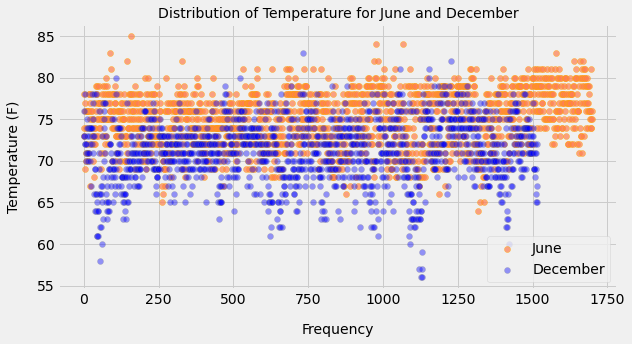

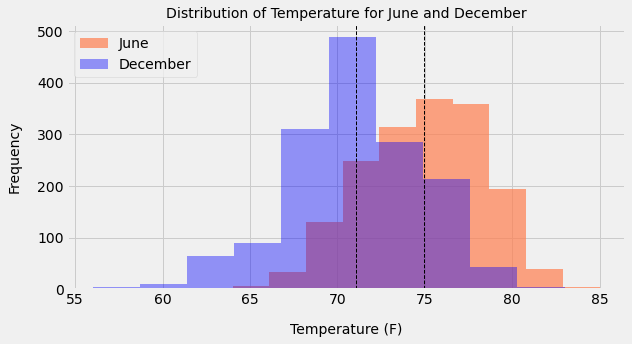

In [156]:
fig, ax = plt.subplots(figsize=(9,5))
plt.scatter(range(len(june_tobs_list)), june_tobs_list, alpha=0.7, label="June", color="coral", edgecolors='orange')
plt.scatter(range(len(dec_tobs_list)), dec_tobs_list, alpha=0.4, label="December", color="blue", edgecolors='grey')
plt.ylabel("Temperature (F)", fontsize=14, labelpad=16)
plt.xlabel("Frequency", fontsize=14, labelpad=16)
plt.title(f"Distribution of Temperature for June and December", fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("Plot_Images/june_dec_temp_scatter.jpeg")
plt.show()   

fig, ax = plt.subplots(figsize=(9,5))
df_june.hist(column=['tobs'], ax=ax, alpha=0.7, label="June", color="coral")
df_dec.hist(column=['tobs'], ax=ax, alpha=0.4, label="December", color="blue")
plt.axvline(avg_temp_june, color="black", linestyle='dashed', linewidth=1)
plt.axvline(avg_temp_dec, color="black", linestyle='dashed', linewidth=1)
plt.xlabel("Temperature (F)", fontsize=14, labelpad=16)
plt.ylabel("Frequency" , fontsize=14, labelpad=16)
plt.title(f"Distribution of Temperature for June and December", fontsize=14)
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("Plot_Images/june_dec_temp_hist.jpeg")
plt.show()   

- *The scatter plot and histogram suggest that the month of June seems to have higher temperature compared to December.* 

## Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
- *Used unpaired independent T-test with unequal variance, because sample sizes for the months of June and December are unequal.*
- *There are 1700 samples for June and 1517 samples for December, and so cannot be paired in a before-after sense.*

In [157]:
res = stats.ttest_ind(june_tobs_list, dec_tobs_list, equal_var=False)
print(res)


Ttest_indResult(statistic=31.35503692096242, pvalue=4.193529835915755e-187)


## Analysis
* The p-value in this case is 4.193529835915755e-187, which is far less than the standard thresholds of 0.05 or 0.01. 
* Based on the p-value, it can be concluded that there is a statistically significant difference between the June temperature and the December temperature.
* June has higher temperatures than December.

# Bonus Challenge Assignment: Temperature Analysis II

In [158]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [159]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
my_trip_start_date = '2017-08-01'
my_trip_end_date   = '2017-08-07'

my_trp_get_temps = calc_temps(my_trip_start_date, my_trip_end_date)
tmin, tavg, tmax =  np.ravel(my_trp_get_temps)

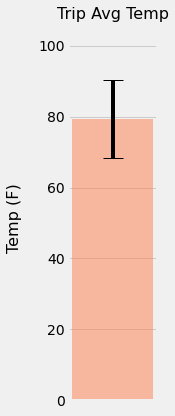

In [160]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = tmax-tmin
fig, ax = plt.subplots(figsize=(2.5,6))
ax.bar(x=0, height=tavg, yerr=y_err, width=0.5, color="coral", alpha=0.5, capsize=10, ecolor="black")
plt.ylim(0,tmax+20)
plt.xticks([])
plt.title('Trip Avg Temp',fontsize=16, pad=16)
plt.ylabel('Temp (F)',fontsize=16,labelpad=16)
plt.tight_layout()
plt.savefig("Plot_Images/trip_avg_temp_bar.jpeg")
plt.show()


### Daily Rainfall Average

In [161]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.

get_tot_rain_fall_for_trip_per_station = session.query(Station.station,Station.name,\
    Station.latitude, Station.longitude, Station.elevation,
    func.sum(Measurement.prcp).label('Total_RainFall')).\
    filter(Measurement.date >= my_trip_start_date).\
    filter(Measurement.date <= my_trip_end_date).\
    filter(Measurement.station == Station.station).\
    group_by(Station.station,Station.name,\
    Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()  

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# display
pd.DataFrame(get_tot_rain_fall_for_trip_per_station, columns=['station', 'name', 'latitude', 'longitude', \
    'elevation', 'Total_RainFall'])

,station,name,latitude,longitude,elevation,Total_RainFall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [162]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [163]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Defined above

my_trip_start_date   = dt.datetime.strptime(my_trip_start_date, '%Y-%m-%d').date()
my_trip_end_date = dt.datetime.strptime(my_trip_end_date, '%Y-%m-%d').date()

trip_length =  my_trip_end_date - my_trip_start_date    
trip_length_in_days = trip_length.days


# Use the start and end date to create a range of dates

trip_dates = [dt.datetime.strftime(my_trip_start_date,'%Y-%m-%d')]
normals = [(tmin,tavg,tmax)]
my_trip_next_date = my_trip_start_date
for i in range(trip_length_in_days):
    
    #Save a list of strings in the format %Y-%m-%d
    trip_dates.append(dt.datetime.strftime((my_trip_next_date + dt.timedelta(days=1)), '%Y-%m-%d'))

    # Strip off the year
    stripped_date = dt.datetime.strftime((my_trip_next_date + dt.timedelta(days=1)), '%m-%d')
    # Use the `daily_normals` function to calculate the normals for each date string 
    # and append the results to a list called `normals`.
    tmin,tavg,tmax = np.ravel(daily_normals(stripped_date))
    normals.append((tmin,tavg,tmax))

    my_trip_next_date = my_trip_next_date + dt.timedelta(days=1)


In [164]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['Tmin', 'Tavg', 'Tmax'], index=trip_dates)
trip_df

,Tmin,Tavg,Tmax
2017-08-01,72.0,79.250000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


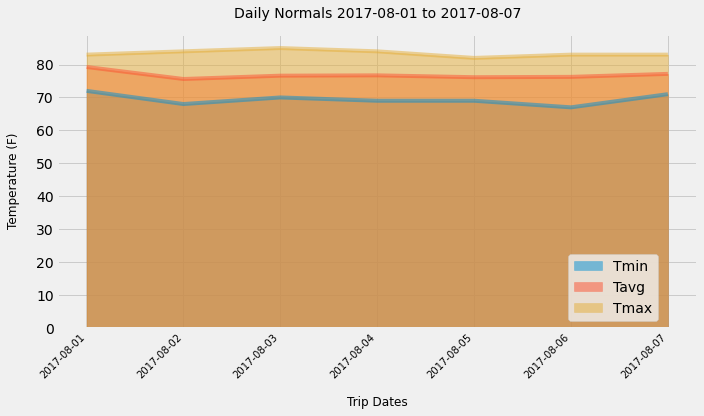

In [165]:
# Plot the daily normals as an area plot with `stacked=False`

fig, ax = plt.subplots(figsize=(10,6))
trip_df.plot.area(ax=ax,stacked=False)
plt.xticks(range(len(trip_dates)), trip_dates, rotation=45, ha='right', fontsize=10)
plt.xlabel("Trip Dates", labelpad=16, fontsize=12)
plt.ylabel("Temperature (F)", labelpad=16, fontsize=12)
plt.title(f"Daily Normals {trip_df.index.min()} to {trip_df.index.max()}", pad=16, fontsize=14)
plt.legend(loc="lower right" , bbox_to_anchor=(0.95, 0))
plt.tight_layout()
plt.savefig("Plot_Images/daily_normals_temp.jpeg")
plt.show()

# Close session

In [166]:
# Close Session
session.close()